<a href="https://colab.research.google.com/github/heriswaya/MLT-Project-1-and-2/blob/main/forecasting_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**

### **Latar Belakang**
Dalam industri ritel, prediksi permintaan (demand forecasting) merupakan komponen krusial dalam pengambilan keputusan bisnis. Dengan meningkatnya kompleksitas faktor yang memengaruhi permintaan seperti musim, promosi, harga kompetitor, hingga kondisi eksternal seperti pandemi, diperlukan pendekatan berbasis data yang andal dan adaptif.

**Time Series Forecasting** adalah pendekatan yang tepat untuk memahami pola permintaan produk dari waktu ke waktu dan memprediksi tren ke depan. Dengan memahami perilaku permintaan harian, perusahaan dapat merencanakan pengadaan barang, promosi, serta strategi logistik yang lebih efisien.

### **Tujuan Proyek**
Proyek ini bertujuan untuk membangun model **Time Series Forecasting** guna memprediksi permintaan harian (`Demand`) untuk produk tertentu dalam sebuah toko ritel. Pendekatan ini akan membantu dalam memahami pola permintaan berdasarkan data historis serta faktor eksternal seperti cuaca, promosi, dan pandemi.

### **Tentang Dataset**
Dataset ini merupakan hasil modifikasi dari *Retail Store Inventory Forecasting Dataset*. Versi ini telah dikoreksi dari kesalahan ID dan ditambahkan fitur `Epidemic` untuk mensimulasikan kondisi pandemi seperti COVID-19. Dataset ini sangat relevan untuk eksperimen time series karena mencakup fitur-fitur penting:

- Tanggal transaksi (`Date`)
- Informasi produk dan toko
- Tingkat inventaris dan unit terjual
- Faktor eksternal: cuaca, musim, promosi, dan pandemi
- Target: **Demand** harian

## **Import Library**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

In [36]:
# URL file CSV dari GitHub heriswaya (ubah menjadi link raw)
url = 'https://raw.githubusercontent.com/heriswaya/MLT-Project-1-and-2/main/sales_data.csv'

# Load dataset
df = pd.read_csv(url)

# Tampilkan 5 baris pertama
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


## **Exploratory Data Analysis (EDA)**

### Description Variabel

In [37]:
# Tampilkan info awal
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null

In [38]:
# Konversi kolom 'Date' ke datetime
df['Date'] = pd.to_datetime(df['Date'])

# Statistik deskriptif
print("\nDeskripsi Statistik:")
print(df.describe())


Deskripsi Statistik:
                      Date  Inventory Level    Units Sold  Units Ordered  \
count                76000     76000.000000  76000.000000   76000.000000   
mean   2023-01-15 12:00:00       301.062842     88.827316      89.090645   
min    2022-01-01 00:00:00         0.000000      0.000000       0.000000   
25%    2022-07-09 18:00:00       136.000000     58.000000       0.000000   
50%    2023-01-15 12:00:00       227.000000     84.000000       0.000000   
75%    2023-07-24 06:00:00       408.000000    114.000000     121.000000   
max    2024-01-30 00:00:00      2267.000000    426.000000    1616.000000   
std                    NaN       226.510161     43.994525     162.404627   

              Price      Discount     Promotion  Competitor Pricing  \
count  76000.000000  76000.000000  76000.000000        76000.000000   
mean      67.726028      9.087039      0.328947           69.454029   
min        4.740000      0.000000      0.000000            4.290000   
25%      

### Check Missing Value

In [39]:
# Cek missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Price                 0
Discount              0
Weather Condition     0
Promotion             0
Competitor Pricing    0
Seasonality           0
Epidemic              0
Demand                0
dtype: int64


Terlihat bahwa data yang digunakan itu tidak ada missing value, sehingga tidak perlu ada perlakuan dalam bagian ini.

### Check Outliers

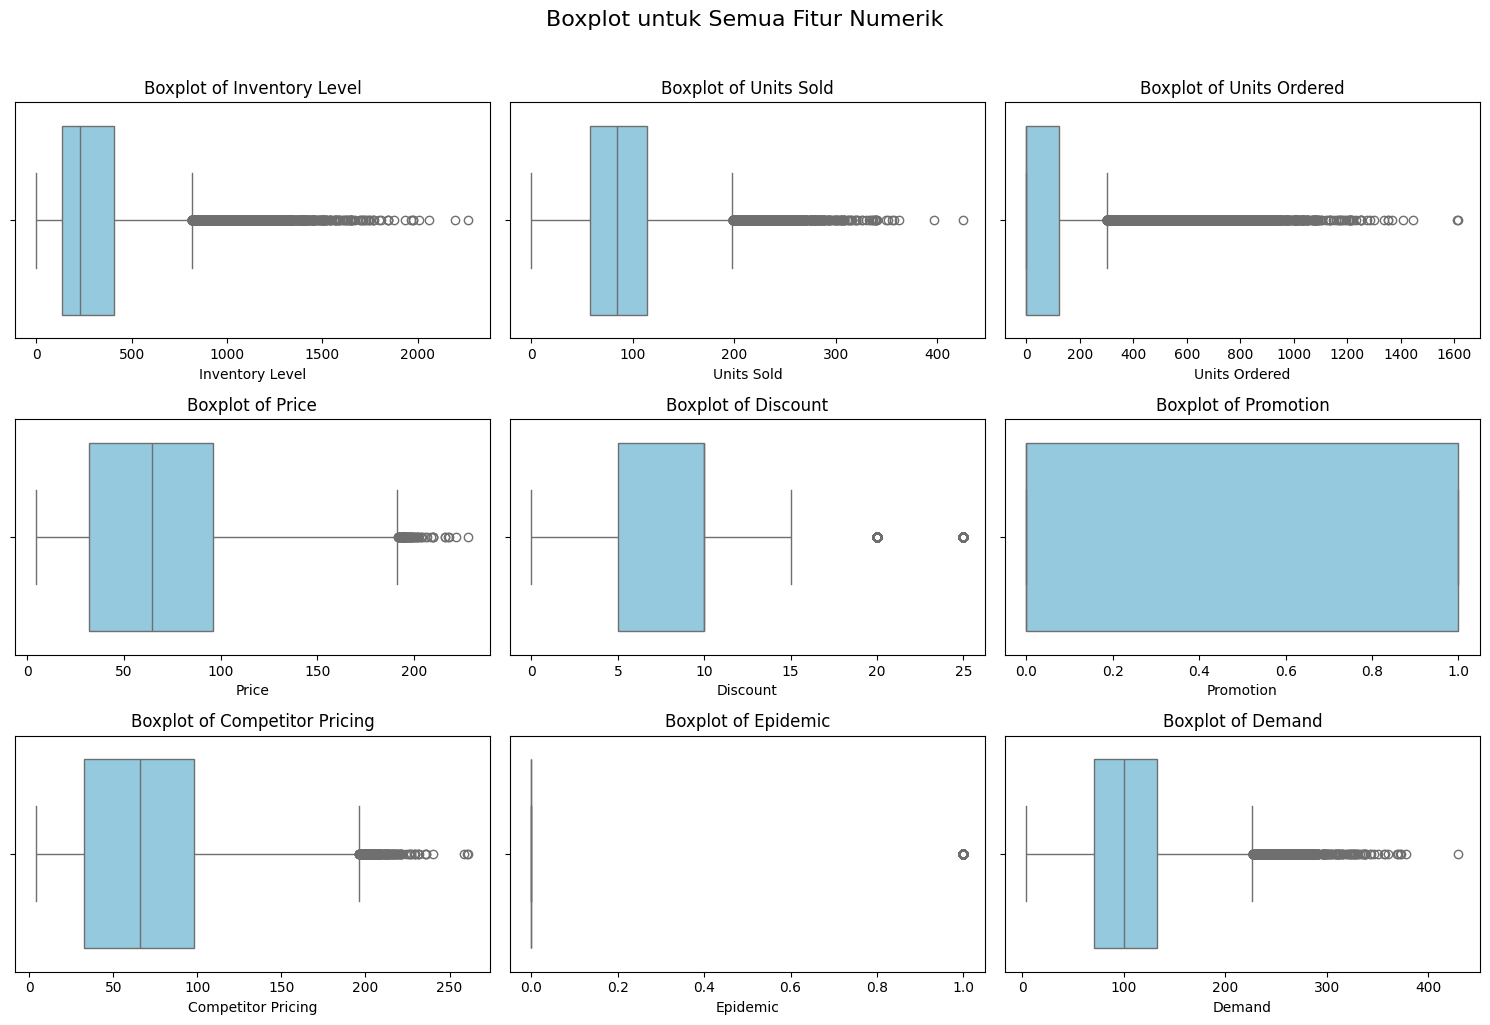

In [40]:
# Pilih hanya kolom numerik
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Buat boxplot untuk setiap fitur numerik
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle('Boxplot untuk Semua Fitur Numerik', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Berdasarkan hasil visualisasi boxplot terhadap seluruh fitur numerik, terlihat bahwa **hampir semua fitur memiliki outlier**, terutama pada kolom:

* `Inventory Level`
* `Units Sold`
* `Units Ordered`
* `Price`
* `Competitor Pricing`
* `Demand`

Sementara itu, kolom seperti `Discount` memiliki beberapa nilai ekstrem, namun jumlahnya tidak terlalu signifikan. Kolom `Promotion` dan `Epidemic` tidak menunjukkan outlier karena merupakan fitur biner (0/1).

### ✦ Apakah Perlu Ditangani?

Karena proyek ini bertujuan untuk **forecasting time series**, maka pendekatan terhadap outlier berbeda dengan model supervised learning biasa:

* **Tidak semua outlier harus dihapus atau ditangani secara agresif.**
* Dalam konteks forecasting, outlier dapat merepresentasikan **kejadian musiman, promosi besar-besaran, atau kondisi khusus seperti pandemi (COVID-19)**.
* Misalnya, lonjakan `Units Ordered` bisa saja terjadi karena promosi besar (lihat juga fitur `Promotion`) atau pengaruh `Epidemic`.

### ✦ Keputusan:

> **Outlier tidak akan dihapus pada tahap ini**, karena:

1. Mereka bisa mengandung **informasi penting terkait tren musiman atau siklus bisnis**.
2. Data ini digunakan untuk *time series forecasting*, di mana menjaga kontinuitas dan keutuhan data historis sangat krusial.
3. Outlier yang benar-benar anomali akan lebih baik ditangani pada tahap **residual analysis** setelah pemodelan, atau dengan metode robust saat pemodelan.

---

### Univariate Analysis

In [41]:
# Pisahkan fitur numerik dan kategorikal
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Fitur Numerik:", numerical_features)
print("Fitur Kategorikal:", categorical_features)

Fitur Numerik: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'Demand']
Fitur Kategorikal: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']


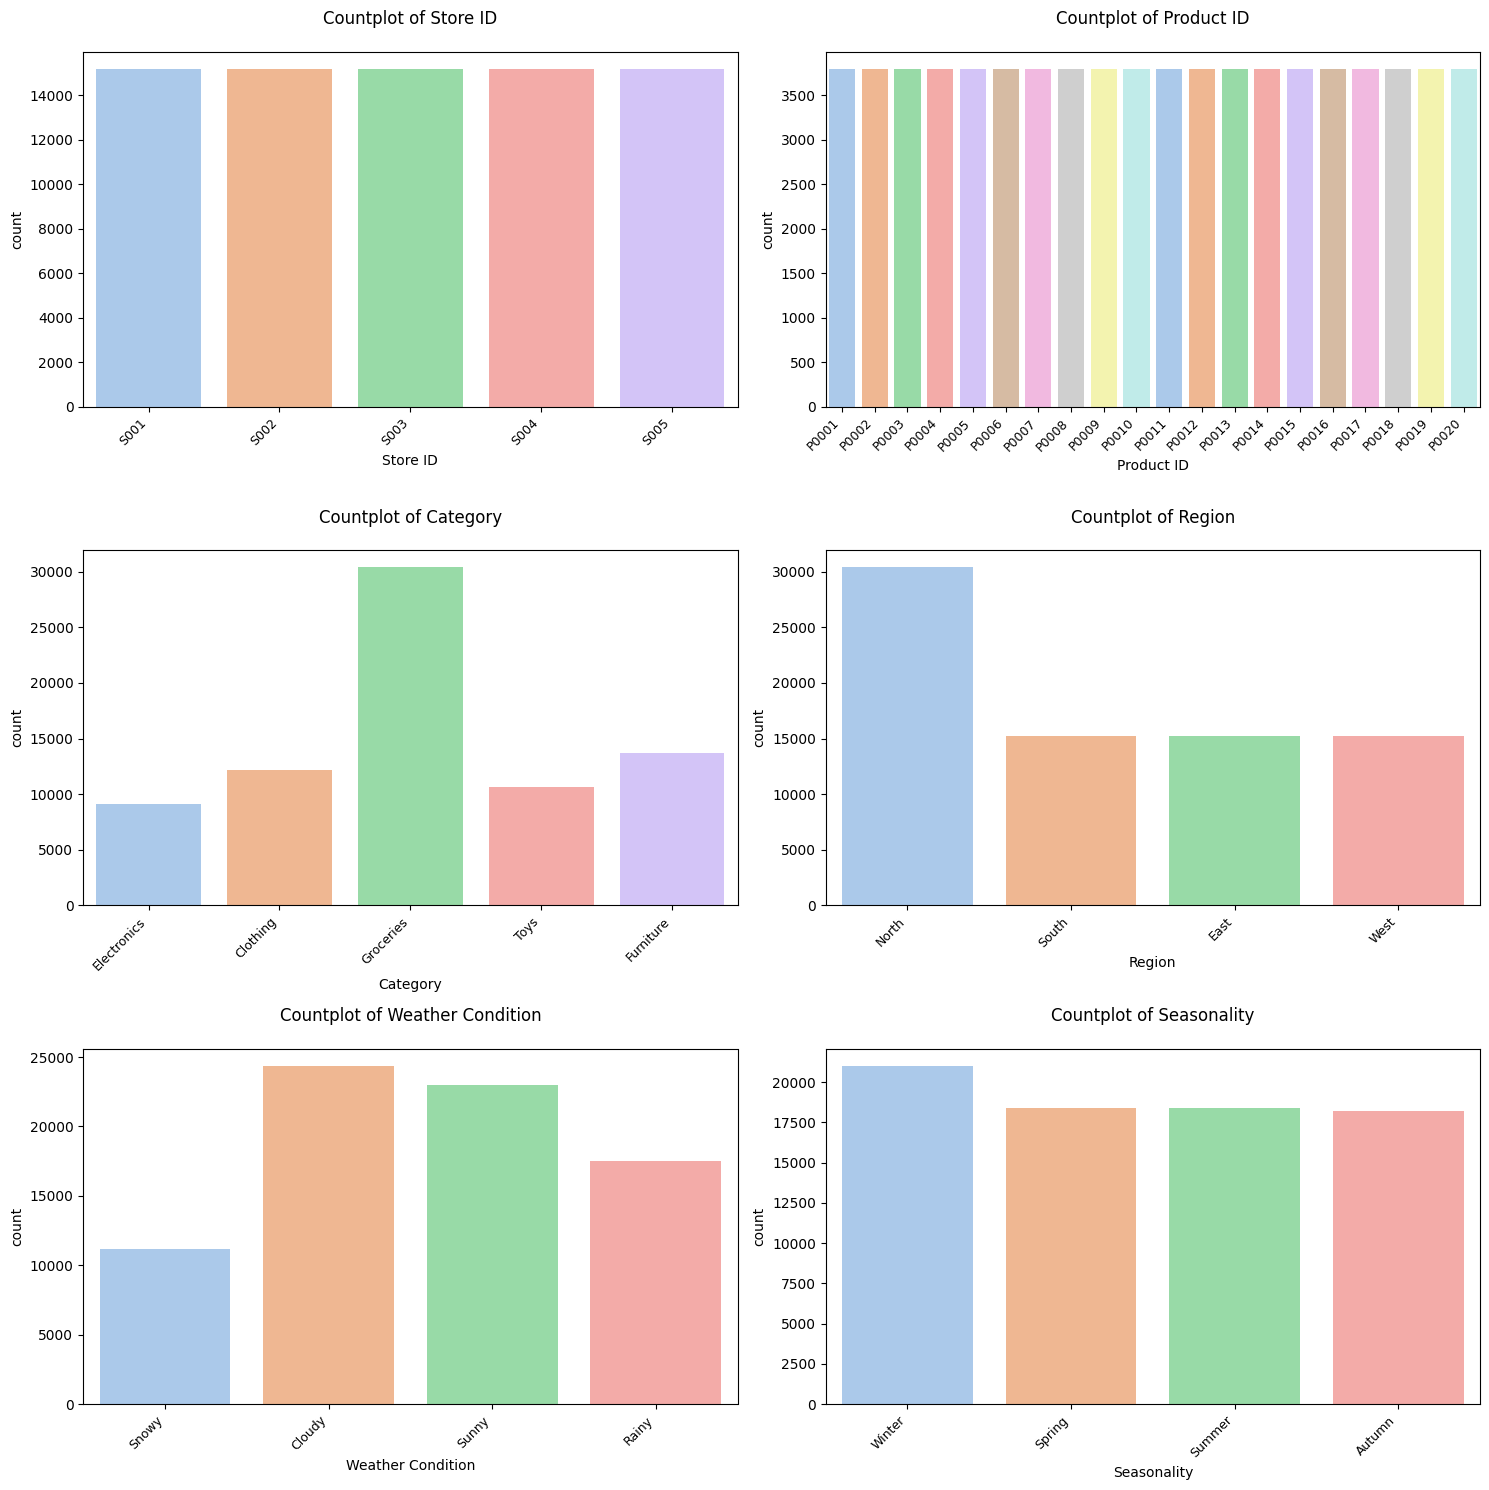

In [42]:
# Visualisasi fitur kategorikal
# Hitung jumlah fitur kategorikal
n_cat = len(categorical_features)
cols = 2  # Jumlah kolom yang diinginkan
rows = (n_cat + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# Buat figure dengan ukuran yang lebih besar
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Atur spacing antar subplot
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten axes jika lebih dari 1 baris
if rows > 1:
    axes = axes.flatten()

# Plot setiap fitur kategorikal
for i, col in enumerate(categorical_features):
    # Buat plot
    sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])

    # Atur title dengan padding
    axes[i].set_title(f'Countplot of {col}', pad=20)

    # Rotasi label x-axis dan atur font size
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)

    # Atur layout untuk mencegah text overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(),
                           rotation=45,
                           ha='right',
                           fontsize=9)

# Sembunyikan axes yang tidak terpakai
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

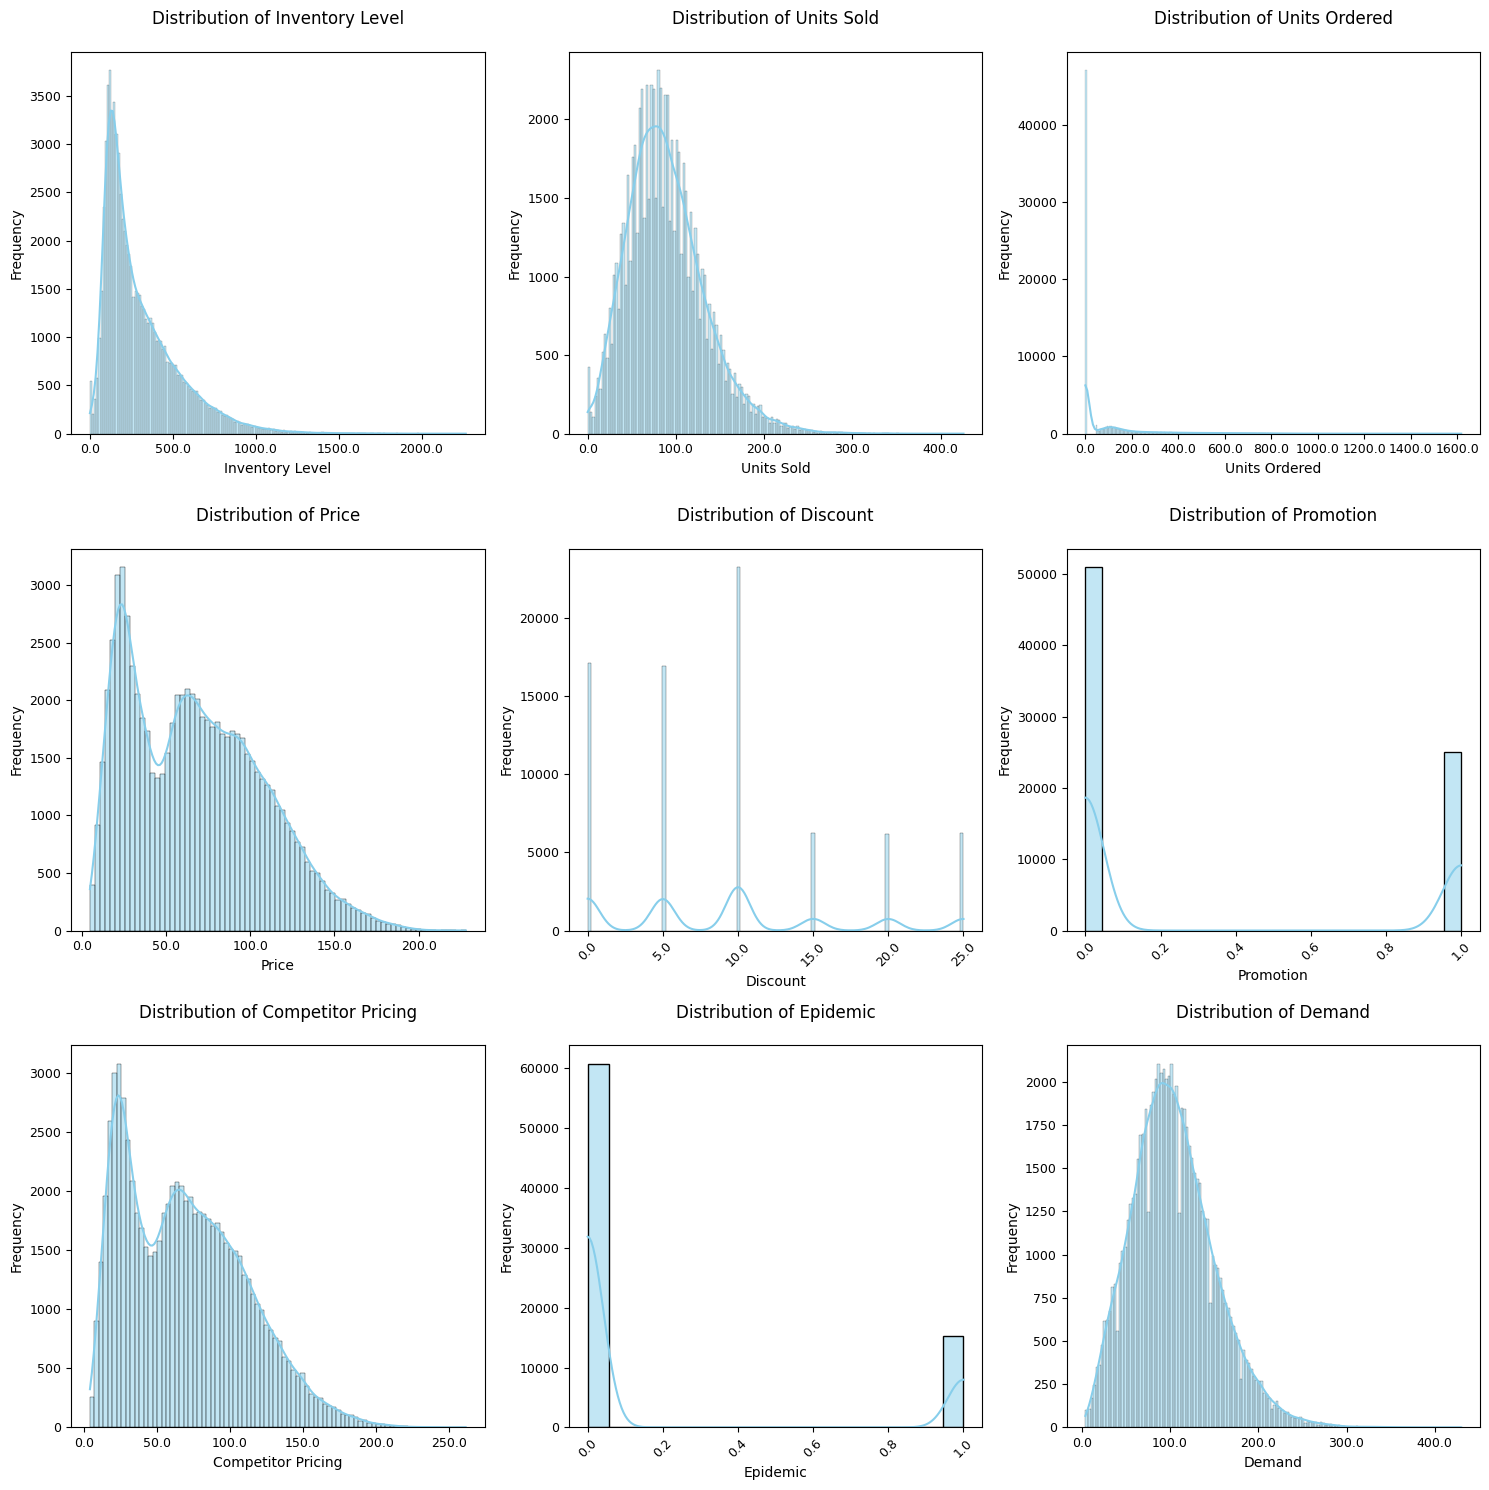

In [43]:
# Visualisasi Fitur Numerik
# Hitung jumlah fitur numerik
n_num = len(numerical_features)
cols = 3  # Jumlah kolom yang diinginkan
rows = (n_num + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# Buat figure dengan ukuran yang disesuaikan
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Atur spacing antar subplot
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten axes jika lebih dari 1 baris
if rows > 1:
    axes = axes.flatten()

# Plot setiap fitur numerik
for i, col in enumerate(numerical_features):
    # Buat histogram dengan KDE
    sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])

    # Atur title dengan padding
    axes[i].set_title(f'Distribution of {col}', pad=20, fontsize=12)

    # Atur label sumbu x
    axes[i].set_xlabel(col, fontsize=10)

    # Atur label sumbu y
    axes[i].set_ylabel('Frequency', fontsize=10)

    # Atur tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=9)

    # Format angka pada sumbu jika perlu
    axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

    # Rotasi label x jika diperlukan
    if len(df[col].unique()) < 10:  # Jika data diskrit
        axes[i].tick_params(axis='x', rotation=45)

# Sembunyikan axes yang tidak terpakai
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Univariate analysis bertujuan untuk melihat distribusi masing-masing fitur secara individu.

- Untuk **fitur kategorikal**, digunakan *countplot* untuk melihat frekuensi masing-masing kategori.
- Untuk **fitur numerik**, digunakan *histogram* untuk melihat sebaran nilai, apakah normal, skewed, atau multimodal.

Hasil analisis ini penting untuk memahami karakteristik dasar tiap fitur sebelum dilakukan pemodelan lebih lanjut.


### Multivariate Analysis

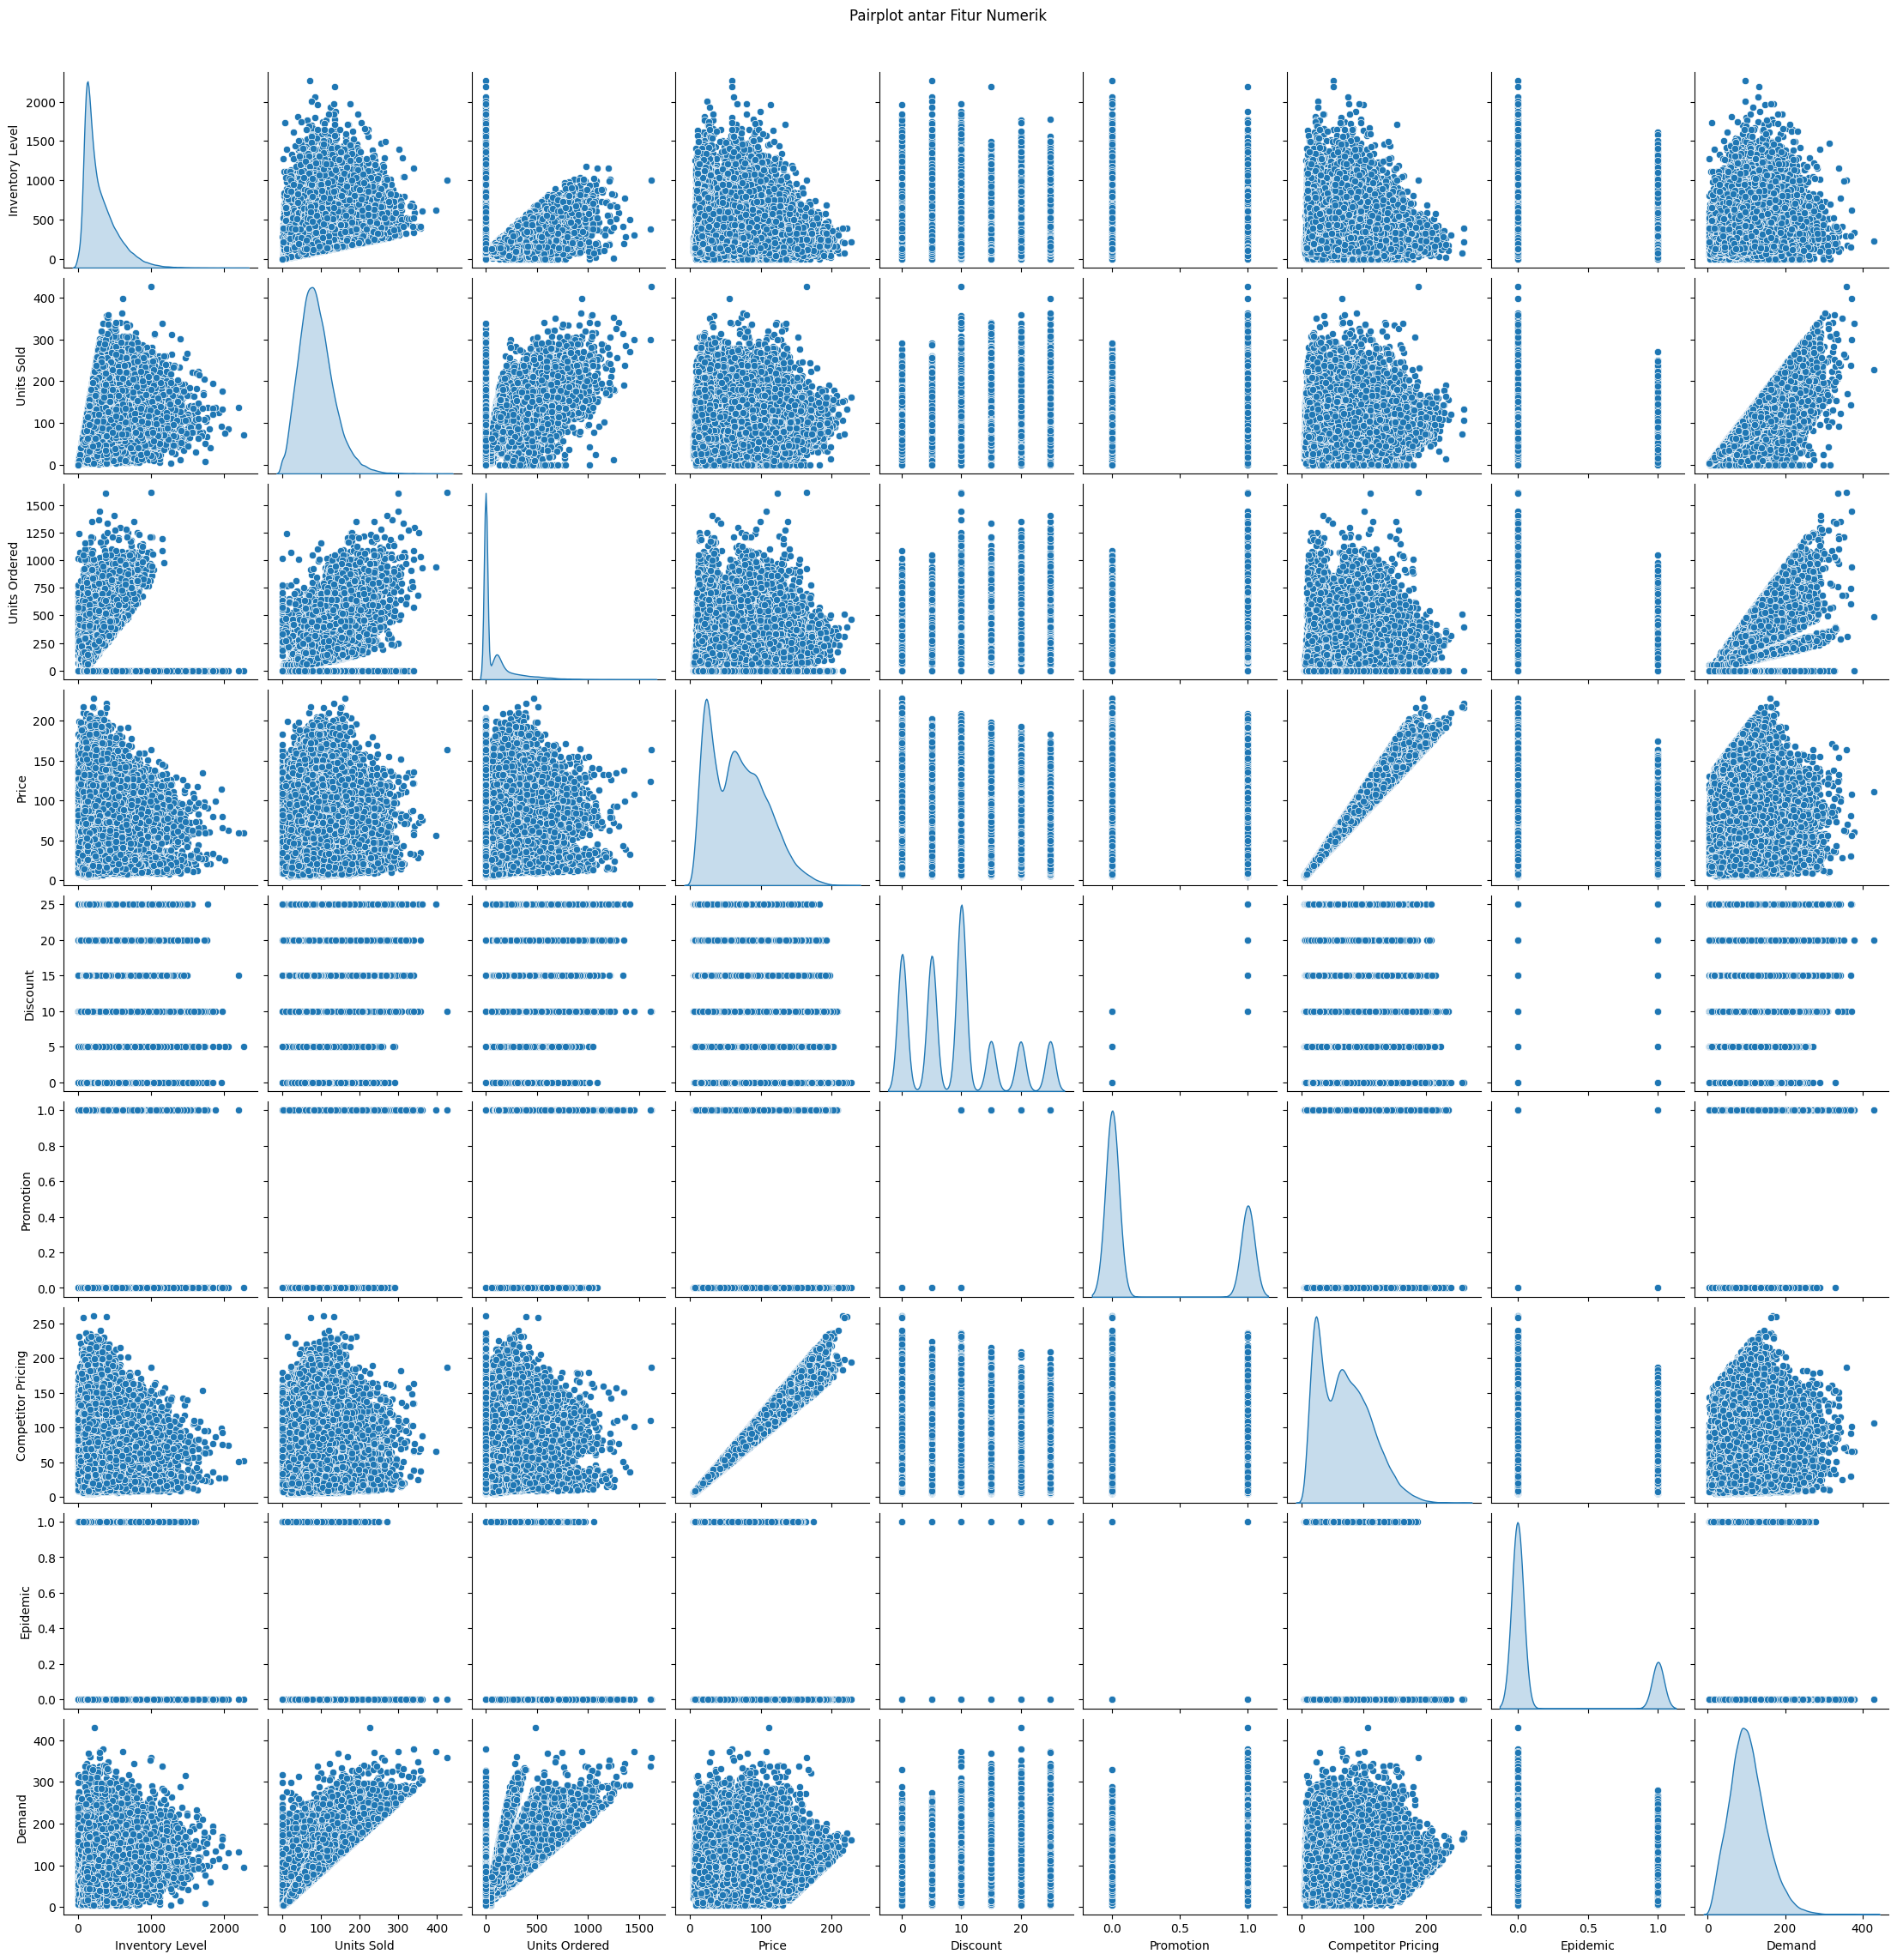

In [44]:
# Pairplot antar fitur numerik untuk melihat hubungan dan distribusi
sns.pairplot(df[numerical_features], diag_kind='kde')
plt.suptitle('Pairplot antar Fitur Numerik', y=1.02)
plt.show()

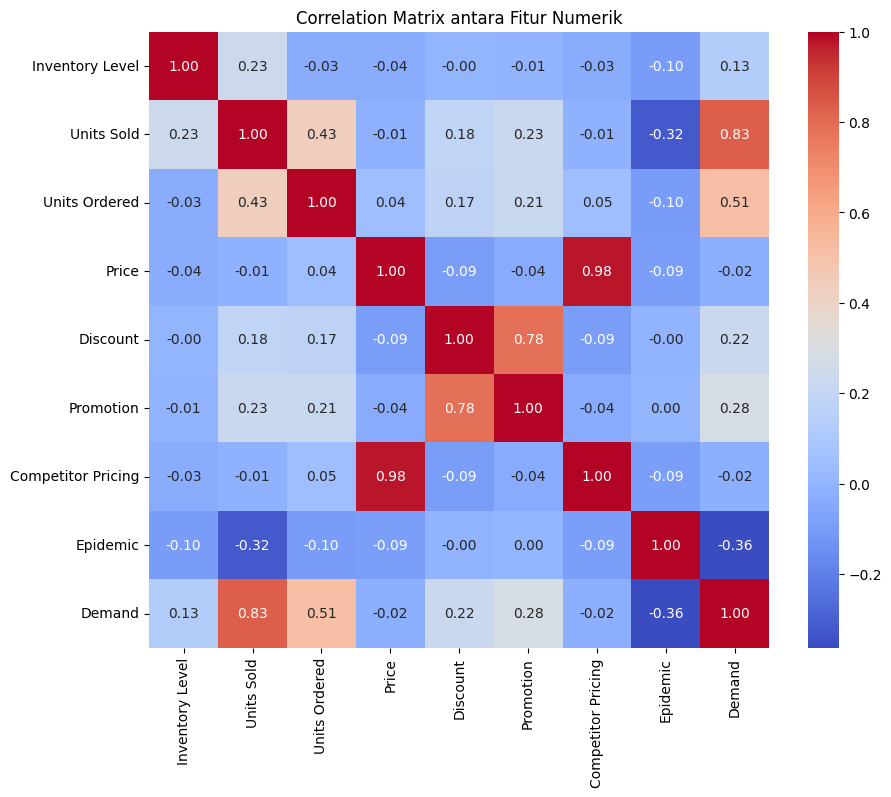

In [45]:
# Korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix antara Fitur Numerik')
plt.show()

Untuk melihat hubungan antar fitur numerik sekaligus dalam satu visualisasi yang komprehensif, digunakan `pairplot`.

- Pairplot menunjukkan scatterplot untuk setiap pasangan fitur.
- Bagian diagonal menampilkan distribusi dari masing-masing fitur (menggunakan KDE).
- Korelasi visual antara fitur dan target `Demand` dapat dilihat secara langsung dari pola sebarannya.
- **Heatmap korelasi** digunakan untuk melihat hubungan linear antar fitur numerik.

Analisis ini membantu mengidentifikasi fitur-fitur dengan pengaruh kuat terhadap permintaan (demand), yang sangat penting dalam model prediksi.


## **Data Preparation**

In [46]:
# Urutkan data berdasarkan tanggal
df = df.sort_values('Date')

# Tampilkan 5 baris teratas untuk memastikan perubahan
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
72,2022-01-01,S004,P0013,Groceries,West,136,104,385,20.24,10,Snowy,0,18.90,Winter,0,110
71,2022-01-01,S004,P0012,Electronics,West,111,111,113,118.15,0,Snowy,0,133.46,Winter,0,103
70,2022-01-01,S004,P0011,Clothing,West,195,60,293,52.89,0,Snowy,0,62.29,Winter,0,61
69,2022-01-01,S004,P0010,Groceries,West,223,120,597,30.02,0,Snowy,0,29.15,Winter,0,128


In [47]:
# Cek tipe data untuk melihat apakah encoding diperlukan
df.dtypes

,0
Date,datetime64[ns]
Store ID,object
Product ID,object
Category,object
Region,object
Inventory Level,int64
Units Sold,int64
Units Ordered,int64
Price,float64
Discount,int64


Untuk membuat model forecasting yang efisien dan tetap mencerminkan kompleksitas data, dipilih satu toko saja yaitu `S001` dengan kelima kategori produk:

- Electronics
- Clothing
- Groceries
- Toys
- Furniture

Pendekatan ini cukup untuk mengevaluasi performa model berdasarkan variasi kategori. Strategi ini juga bersifat scalable: jika ingin membuat model untuk toko lain, cukup ubah filter `Store ID`.

In [48]:
# Pilih satu toko
selected_store = 'S001'

# Filter data
df_subset = df[df['Store ID'] == selected_store].copy()

# Drop fitur yang tidak relevan
df_subset.drop(columns=[
    'Product ID', 'Store ID', 'Region', 'Weather Condition', 'Seasonality'
], inplace=True)

# Optional: encode fitur kategorikal (hanya 'Category')
df_subset = pd.get_dummies(df_subset, columns=['Category'], drop_first=True)

# Simpan nama-nama kolom numerik selain target
numerical_features = df_subset.drop(columns=['Demand']).select_dtypes(include=['int64', 'float64']).columns

In [49]:
# Standarisasi fitur numerik (selain Demand)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_subset[numerical_features] = scaler.fit_transform(df_subset[numerical_features])

# Cek hasil akhir
df_subset.head()

,Date,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys
0,2022-01-01,-0.363964,0.352161,1.084402,0.139831,-0.538724,-0.70014,0.426729,-0.5,115,True,False,False,False
19,2022-01-01,-0.051331,-1.168887,-0.571379,0.887009,-0.538724,-0.70014,1.189037,-0.5,43,False,True,False,False
18,2022-01-01,0.014719,-0.592733,-0.571379,0.754805,0.128318,-0.70014,0.874142,-0.5,58,False,True,False,False
17,2022-01-01,0.014719,-0.200948,-0.571379,-0.353440,-0.538724,-0.70014,-0.390344,-0.5,66,False,False,True,False
16,2022-01-01,-0.658984,-0.638825,-0.571379,-1.247091,-1.205766,-0.70014,-1.200700,-0.5,75,False,False,False,True


### Split Train-Test

Karena data bersifat time series, maka data dibagi berdasarkan urutan waktu. Model tidak boleh belajar dari data masa depan.

Dua model digunakan:
1. Linear Regression → sebagai model baseline yang sederhana.
2. Random Forest Regressor → untuk menangkap pola non-linear yang mungkin terjadi antara fitur dan permintaan (Demand).


In [50]:
# Buat salinan untuk proses supervised time series
df_ts = df_subset.copy()

# Ubah kolom Date ke datetime
df_ts['Date'] = pd.to_datetime(df['Date'][df_ts.index])

# Urutkan berdasarkan waktu
df_ts.sort_values('Date', inplace=True)

# Buat lag feature (contoh: Demand kemarin)
df_ts['Demand_lag1'] = df_ts['Demand'].shift(1)

# Drop baris pertama karena ada NaN dari shift
df_ts = df_ts.dropna().reset_index(drop=True)

# Tentukan fitur dan target
X = df_ts.drop(columns=['Date', 'Demand'])
y = df_ts['Demand']

# Split berdasarkan waktu: 80% train, 20% test
split_idx = int(0.8 * len(df_ts))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [51]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 15199
Total # of sample in train dataset: 12159
Total # of sample in test dataset: 3040


## **Model Development**

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## **Evaluasi**

In [54]:
# Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"📊 {model_name} Evaluation")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print("-" * 30)

# Jalankan evaluasi untuk kedua model
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")


📊 Linear Regression Evaluation
MAE  : 15.32
RMSE : 20.27
------------------------------
📊 Random Forest Regressor Evaluation
MAE  : 11.31
RMSE : 15.03
------------------------------


### Visualisasi Hasil Prediksi

In [64]:
# Ambil kembali tanggal dari test set
dates_test = df_ts['Date'].iloc[split_idx:].reset_index(drop=True)

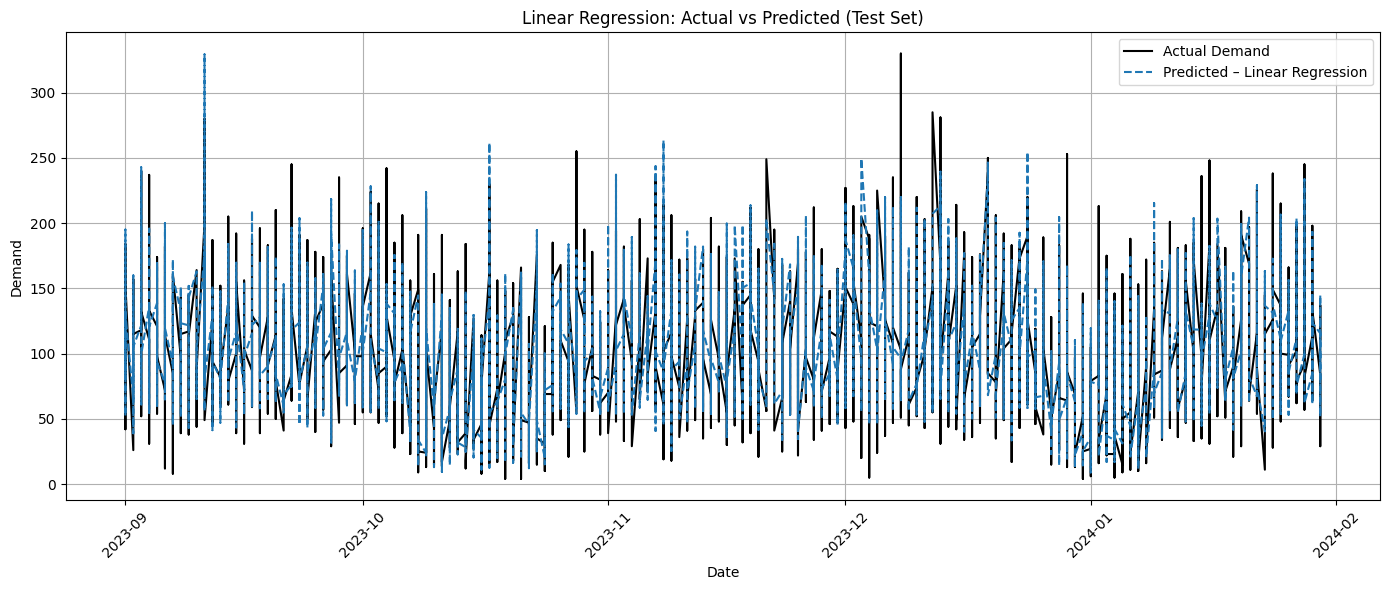

In [59]:
# Linear Regression
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test, label='Actual Demand', color='black')
plt.plot(dates_test, y_pred_lr, label='Predicted – Linear Regression', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted (Test Set)')
plt.xlabel('Date'); plt.ylabel('Demand')
plt.legend(); plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()

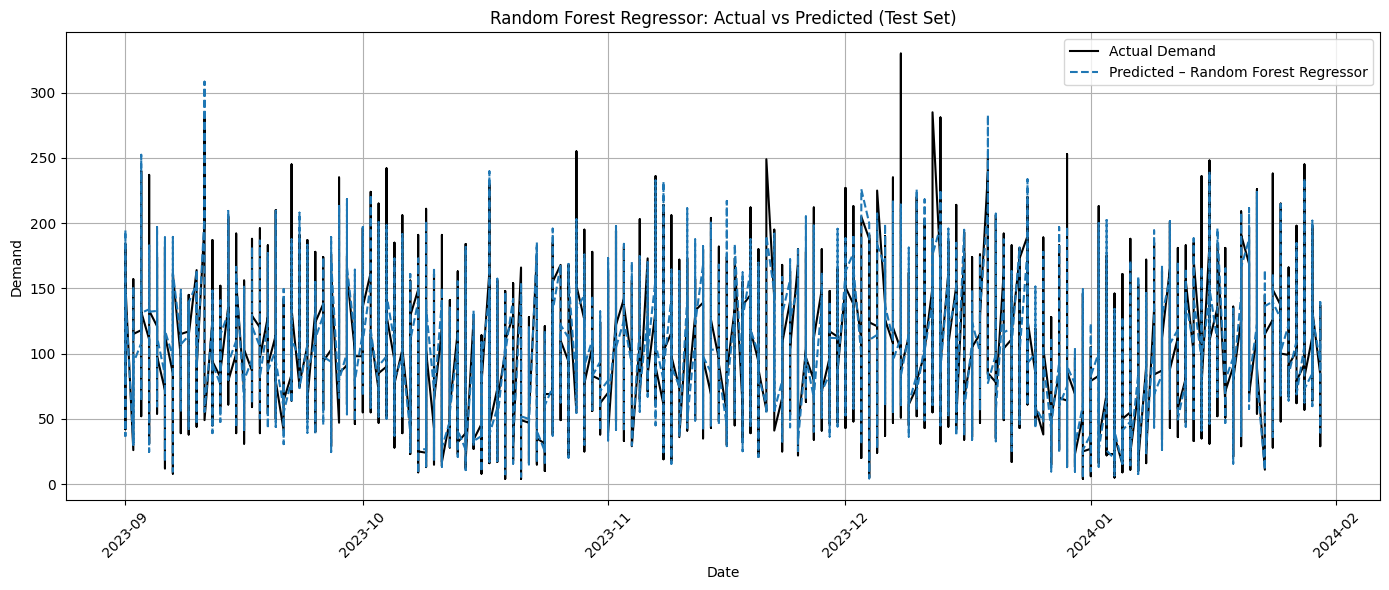

In [63]:
# Random Forest Regressor
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test, label='Actual Demand', color='black')
plt.plot(dates_test, y_pred_rf, label='Predicted – Random Forest Regressor', linestyle='--')
plt.title('Random Forest Regressor: Actual vs Predicted (Test Set)')
plt.xlabel('Date'); plt.ylabel('Demand')
plt.legend(); plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()

### Generate Future Forecast

In [60]:
from datetime import timedelta

# ====== Konfigurasi ======
forecast_horizon = 90            # 90 hari ≈ 3 bulan (ubah 60–150 utk 2-5 bln)
last_date        = df_ts['Date'].iloc[-1]

# ====== Siapkan frame future kosong ======
future_dates = pd.date_range(last_date + timedelta(days=1),
                             periods=forecast_horizon, freq='D')
future_df    = pd.DataFrame({'Date': future_dates})

# Gunakan konstanta/mean utk fitur non-lag
const_values = df_subset.mean()

for col in X.columns:                 # semua fitur kecuali Demand
    if col == 'Demand_lag1':
        future_df[col] = np.nan       # nanti diisi rekursif
    else:
        future_df[col] = const_values.get(col, 0)

# ====== Forecast rekursif ======
prev_demand = df_ts['Demand'].iloc[-1]

preds = []
for i in range(forecast_horizon):
    future_df.loc[i, 'Demand_lag1'] = prev_demand
    x_row = future_df[X.columns].iloc[i].values.reshape(1, -1)
    pred  = rf_model.predict(x_row)[0]
    preds.append(pred)
    prev_demand = pred               # jadikan lag utk langkah berikut

future_df['Forecast_Demand'] = preds


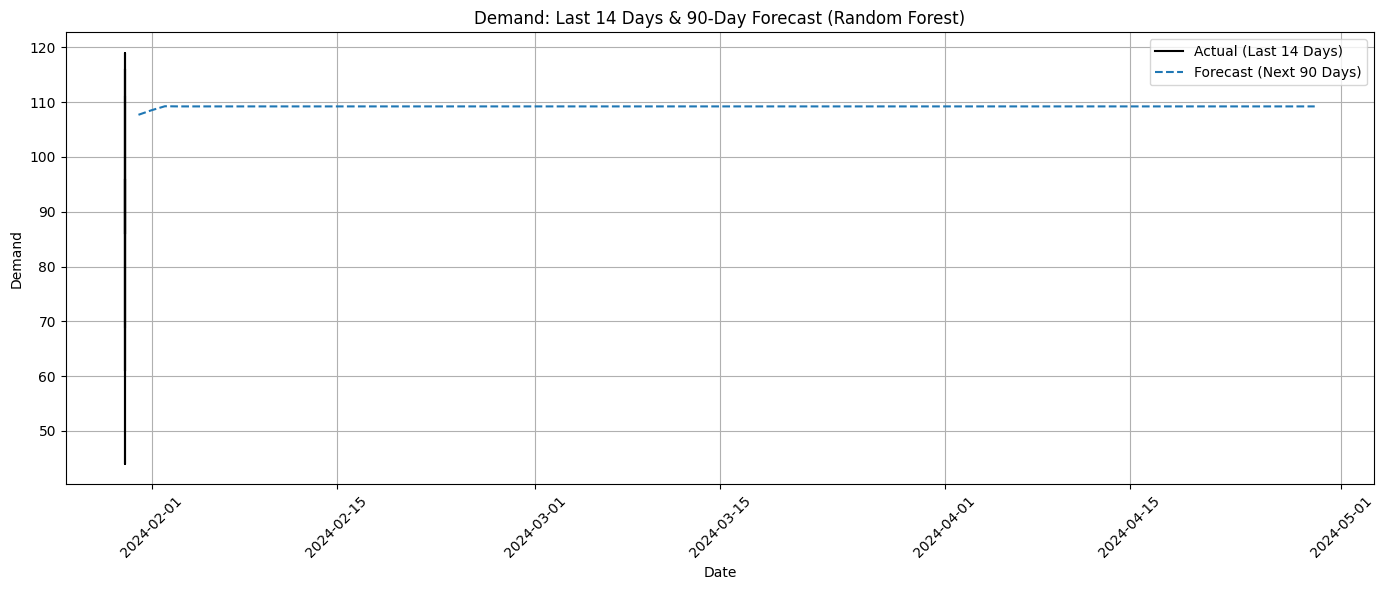

In [62]:
# Visualisasi 2 minggu terakhir + forecast
plt.figure(figsize=(14,6))

# Ambil 14 hari terakhir aktual
last_14   = df_ts[['Date','Demand']].tail(14)

plt.plot(last_14['Date'], last_14['Demand'],
         label='Actual (Last 14 Days)', color='black')

plt.plot(future_df['Date'], future_df['Forecast_Demand'],
         label='Forecast (Next {} Days)'.format(forecast_horizon), linestyle='--')

plt.title('Demand: Last 14 Days & {}-Day Forecast (Random Forest)'.format(forecast_horizon))
plt.xlabel('Date'); plt.ylabel('Demand')
plt.legend(); plt.xticks(rotation=45); plt.grid(True); plt.tight_layout()
plt.show()
